In [67]:
import pandas as pd 
import numpy as np 
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, PredefinedSplit, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier

In [31]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [32]:
def make_submission(df_test,df_test_raw, model):
    y_hat_test = model.predict(df_test)
    df_final = pd.DataFrame({
        df_test_raw.columns[0]: df_test_raw.iloc[:, 0],  
        "Transported": y_hat_test.astype(bool)   
    })
    return df_final

### After testing several imputation techiques, I found out that KNN imputer has the best contribution

In [33]:
def KNN_Imputer(df_train, df_test):
    df_tr_imp = df_train.copy()
    df_ts_imp = df_test.copy()

    # Split cabin and passenger ID features
    for df in [df_tr_imp, df_ts_imp]:
        df[['CabinDeck', 'CabinNum', 'CabinSide']] = df['Cabin'].str.split('/', expand=True)
        df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
        df[['GroupId', 'PersId']] = df['PassengerId'].str.split('_', expand=True)
        df['GroupId'] = pd.to_numeric(df['GroupId'], errors='coerce')

    numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum', 'GroupId']
    categorical_features = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'CabinDeck', 'CabinSide']

    # Drop unnecessary columns
    df_tr_imp.drop(['Name', 'Cabin', 'PassengerId', 'Transported'], axis=1, inplace=True)
    df_ts_imp.drop(['Name', 'Cabin', 'PassengerId'], axis=1, inplace=True)

    # MinMaxScaler for normalization
    mm = MinMaxScaler()

    # Function to generate category-to-integer mappings
    def find_category_mappings(df, variable):
        return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

    # Function to encode categorical features as integers
    def integer_encode(df, variable, ordinal_mapping):
        df[variable] = df[variable].map(ordinal_mapping)

    # Store mappings for categorical encoding
    category_mappings = {}

    def impute_categorical_features(df, categorical_cols):
        df_copy = df.copy()
        
        # Generate and store mappings for categorical features
        for variable in categorical_cols:
            mappings = find_category_mappings(df_copy, variable)
            category_mappings[variable] = mappings

        # Apply encoding
        for variable in categorical_cols:
            integer_encode(df_copy, variable, category_mappings[variable])  

        # Scale data and apply KNN imputation
        scaled_data = mm.fit_transform(df_copy)
        knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=10,
                         weights='uniform',
                         metric='nan_euclidean'
                        )
        imputed_data = knn_imputer.fit_transform(scaled_data)
        df_copy.iloc[:, :] = mm.inverse_transform(imputed_data)

        # Round values and convert back to original categories
        for col in df_copy.columns:
            df_copy[col] = df_copy[col].round().astype('int')

        for variable in categorical_cols:
            inv_map = {v: k for k, v in category_mappings[variable].items()}
            df_copy[variable] = df_copy[variable].map(inv_map)
        
        return df_copy

    num_imp = KNNImputer(missing_values=np.nan,
                         n_neighbors=10,
                         weights='uniform',
                         metric='nan_euclidean'
                        )

    # Apply KNN imputation separately for numerical and categorical features
    df_tr_imp[numerical_features] = num_imp.fit_transform(df_tr_imp[numerical_features])
    df_ts_imp[numerical_features] = num_imp.transform(df_ts_imp[numerical_features])

    df_tr_imp = impute_categorical_features(df_tr_imp, categorical_features)
    df_ts_imp = impute_categorical_features(df_ts_imp, categorical_features)

    df_tr_imp[categorical_features] = df_tr_imp[categorical_features].astype('category')
    df_ts_imp[categorical_features] = df_ts_imp[categorical_features].astype('category')
    
    return df_tr_imp, df_ts_imp

In [34]:
train_raw, test_raw = pd.read_csv('train.csv'), pd.read_csv('test.csv')
train_imp, test_imp = KNN_Imputer(train_raw, test_raw)

In [35]:
X_xgb = train_imp
X_xgb.dtypes

HomePlanet      category
CryoSleep       category
Destination     category
Age                int32
VIP             category
RoomService        int32
FoodCourt          int32
ShoppingMall       int32
Spa                int32
VRDeck             int32
CabinDeck       category
CabinNum           int32
CabinSide       category
GroupId            int32
PersId             int32
dtype: object

In [36]:
y_xgb = train_raw['Transported']
y_xgb = y_xgb.astype('category')

In [54]:
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum', 'GroupId']


In [55]:
categorical_features = ['HomePlanet', 'Destination', 'CryoSleep', 'VIP', 'CabinDeck', 'CabinSide']


In [39]:
X_norm_xgb = X_xgb.copy()
X_norm_xgb[numerical_features] = preprocessing.StandardScaler().fit(X_norm_xgb[numerical_features]).transform(X_norm_xgb[numerical_features])
X_norm_xgb.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinNum,CabinSide,GroupId,PersId
0,Europa,False,TRAPPIST-1e,0.709690,False,-0.338743,-0.284005,-0.288904,-0.274972,-0.266699,B,-1.175525,P,-1.734409,1
1,Earth,False,TRAPPIST-1e,-0.333956,False,-0.173683,-0.278366,-0.247110,0.212520,-0.227932,F,-1.175525,S,-1.734034,1
2,Europa,False,TRAPPIST-1e,2.031642,True,-0.273628,1.956345,-0.288904,5.687700,-0.223526,A,-1.175525,S,-1.733660,1


In [40]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_norm_xgb, y_xgb, test_size=0.15, random_state=42)

### The train dataset is not big, so I will use Cross-Validation

In [41]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score)
          }
parameters = {
    "learning_rate": [0.001, 0.025, 0.05, 0.075, 0.01, 0.25, 0.5],
    "max_depth":[3,5,8,10]
    }

In [42]:
xgb_cv = GridSearchCV(estimator=XGBClassifier(enable_categorical=True),
                      param_grid=parameters,
                      scoring=scoring,
                      refit='accuracy',
                      cv=cv_strategy
                     )

In [43]:
xgb_cv.fit(X_train_xgb, y_train_xgb)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type...
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.001, 0.025, 0.05, 0.075, 0.01,
                                           0.25, 0.5],
                         'max_depth': [3, 5, 8, 10]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'precision': make_scorer(precision_score, response_method='predict'),
                      'recall': make_scorer(recall_score, response_method='predict')})

In [44]:
y_hat_xgb = xgb_cv.predict(X_test_xgb)

In [45]:
print(classification_report(y_test_xgb, y_hat_xgb))

              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79       657
         1.0       0.78      0.81      0.79       647

    accuracy                           0.79      1304
   macro avg       0.79      0.79      0.79      1304
weighted avg       0.79      0.79      0.79      1304



         Feature  Importance
1      CryoSleep    0.712278
10     CabinDeck    0.044003
9         VRDeck    0.029312
5    RoomService    0.029186
6      FoodCourt    0.026931
0     HomePlanet    0.026406
8            Spa    0.026389
12     CabinSide    0.023292
7   ShoppingMall    0.020342
3            Age    0.014682
11      CabinNum    0.014528
13       GroupId    0.013008
2    Destination    0.012074
14        PersId    0.004424
4            VIP    0.003143


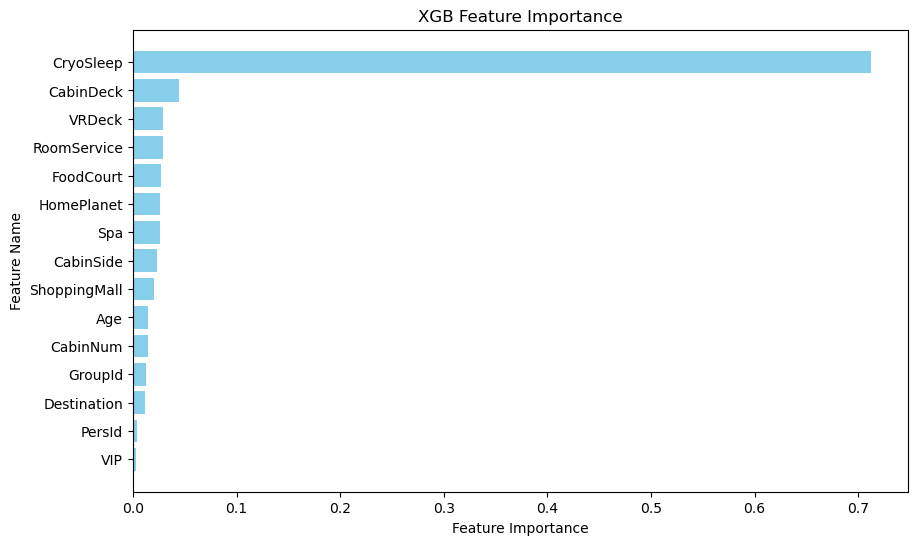

In [46]:
best_xgb_model = xgb_cv.best_estimator_
feature_importances = best_xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train_xgb.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("XGB Feature Importance")
plt.show()

From the above plot, we can see that `PersId` and `VIP` have extremely poor contribution to the model.
I am going to drop those columns

In [47]:
y_hat_sumb = make_submission(test_imp,test_raw, xgb_cv)

In [48]:
y_hat_sumb.to_csv("prediction-01.csv", index=False)

This model has 0.545 score on Kaggle

### CatBoostClassifier

In [58]:
X_cbc = train_imp.drop(['VIP', 'PersId'], axis=1)
y_cbc = train_raw['Transported']
y_cbc = y_xgb.astype('category')

In [56]:
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum', 'GroupId']

In [57]:
categorical_features = ['HomePlanet', 'Destination', 'CryoSleep', 'CabinDeck', 'CabinSide']

In [59]:
X_norm_cbc = X_cbc.copy()
X_norm_cbc[numerical_features] = preprocessing.StandardScaler().fit(X_norm_cbc[numerical_features]).transform(X_norm_cbc[numerical_features])
X_norm_cbc.head(3)

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinNum,CabinSide,GroupId
0,Europa,False,TRAPPIST-1e,0.709690,-0.338743,-0.284005,-0.288904,-0.274972,-0.266699,B,-1.175525,P,-1.734409
1,Earth,False,TRAPPIST-1e,-0.333956,-0.173683,-0.278366,-0.247110,0.212520,-0.227932,F,-1.175525,S,-1.734034
2,Europa,False,TRAPPIST-1e,2.031642,-0.273628,1.956345,-0.288904,5.687700,-0.223526,A,-1.175525,S,-1.733660


In [61]:
X_train_cbc, X_test_cbc, y_train_cbc, y_test_cbc = train_test_split(X_norm_cbc, y_cbc, test_size=0.15, random_state=42)

In [63]:
from catboost import CatBoostClassifier

In [65]:
model_cbc = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', verbose=100)
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
param_grid_cbc = { 
    'iterations': [500, 700],
    'depth': [4, 6, 8, 12],
    'learning_rate': [0.001, 0.025, 0.05, 0.075, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128],
}

In [69]:
cbc_cv = RandomizedSearchCV(
    estimator=model_cbc,
    param_distributions=param_grid_cbc,
    n_iter=20,  
    cv=kf,
    random_state=42,
    n_jobs=-1  
)

In [70]:
cbc_cv.fit(X_train_cbc, y_train_cbc, cat_features=categorical_features)

0:	total: 177ms	remaining: 2m 3s
100:	total: 2s	remaining: 11.8s
200:	total: 4.14s	remaining: 10.3s
300:	total: 5.84s	remaining: 7.75s
400:	total: 7.79s	remaining: 5.81s
500:	total: 10s	remaining: 3.99s
600:	total: 12.1s	remaining: 1.99s
699:	total: 13.9s	remaining: 0us


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000273A2CAD210>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 12],
                                        'iterations': [500, 700],
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': [0.001, 0.025, 0.05,
                                                          0.075, 0.1]},
                   random_state=42)

In [71]:
print("tuned hyperparameters :(best parameters) ",cbc_cv.best_params_)
print("accuracy :",cbc_cv.best_score_)

tuned hyperparameters :(best parameters)  {'learning_rate': 0.075, 'l2_leaf_reg': 5, 'iterations': 700, 'depth': 4, 'border_count': 32}
accuracy : 0.8145893323243272


In [72]:
y_hat_cbc = cbc_cv.predict(X_test_cbc)

In [76]:
test_norm_cbc = test_imp.copy()
test_norm_cbc[numerical_features] = preprocessing.StandardScaler().fit(test_norm_cbc[numerical_features]).transform(test_norm_cbc[numerical_features])
test_norm_cbc.head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinNum,CabinSide,GroupId,PersId
0,Earth,True,TRAPPIST-1e,-0.117635,False,-0.363161,-0.287102,-0.316793,-0.271100,-0.249351,G,-1.188673,S,-1.703425,1
1,Earth,False,TRAPPIST-1e,-0.686944,False,-0.363161,-0.281141,-0.316793,2.284305,-0.249351,F,-1.186723,S,-1.701584,1
2,Europa,True,55 Cancri e,0.167019,False,-0.363161,-0.287102,-0.316793,-0.271100,-0.249351,C,-1.194525,S,-1.701215,1


In [77]:
test_norm_cbc.drop(['VIP', 'PersId'], axis=1, inplace=True)

In [78]:
pred_subm_cbc = make_submission(test_norm_cbc, test_raw, cbc_cv)
pred_subm_cbc.to_csv("prediction-02.csv", index=False)

### The above model gives 0.802 score on Kaggle. 
### After testing several models and configurations, I am ready to present the best configuration in the third part.